In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry
from PIL import Image
import os
import csv

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [3]:
def get_area(gray_image, mask, threshold):
    '''
    Go through the image and get the area of all the pixels above the threshold
    '''
    total = 0
    count = 0
    new_mask = np.zeros(mask.shape)
    for y in range(mask.shape[0]):
        for x in range(mask.shape[1]):
            if mask[y, x]:
                pixel_value = gray_image[y,x][0]
                if pixel_value >= threshold: 
                    total += 1
                    new_mask[y,x] = 1
                count += 1

    print(total/count)
    return new_mask

def get_gradient(gray_image, masks, scores):
    '''
    Go layer by layer during the image
    Plot the 
    '''
    main_mask, _ = get_main_mask(masks, scores)

    gradient = []
    for y in range(main_mask.shape[0]):
        total = 0
        count = 0
        for x in range(main_mask.shape[1]):
            if main_mask[y, x]:
                total += gray_image[y,x][0]
                count += 1
        if count != 0:
            gradient.append(total // count)
        else:
            gradient.append(0)

    return gradient

def get_main_mask(masks, scores):
    sorted_masks = sorted(zip(masks, scores), key=lambda x: x[1], reverse=True)
    for mask in sorted_masks: print(mask[1])
    main_mask = sorted_masks[0][0]
    main_mask_score = sorted_masks[0][1]
    return main_mask, main_mask_score

In [4]:
sam = sam_model_registry["default"](checkpoint="../../../Downloads/sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)

In [5]:
def get_bounding_box(main_mask, new_image):

    boundingBox = {
        "topLeft": None,
        "bottomRight": [0,0],
    }

    topLeft = False

    for i in range(len(new_image)):
        for j in range(len(new_image[0])):
            if not main_mask[i][j]:
                new_image[i][j] = [0, 0, 0]
            else:
                print(i, j)
                if not topLeft:
                    boundingBox["topLeft"] = [j, i]
                    topLeft = True
                boundingBox["bottomRight"] = [max(boundingBox["bottomRight"][0], j), max(boundingBox["bottomRight"][1], i)]
    
    return new_image, boundingBox
        



In [6]:
def get_middle_coordinate(top_left_x, top_left_y, wBox, hbox):
    '''
    Get the center of the box
    '''
    return top_left_x + wBox // 2, top_left_y + hbox // 2


In [7]:
def convertPoint(point, boundingBox, width, height, x_axis, y_axis):
    top_left_x, top_left_y = point
    x = (top_left_x - boundingBox["topLeft"][0]) * (x_axis[1] - x_axis[0]) / width
    y = y_axis[1] - (top_left_y - boundingBox["topLeft"][1]) * (y_axis[1] - y_axis[0]) / height
    return [x, y]


In [8]:
def get_filtered_answer(mask, x0, y0, wBox, hBox, max_x, max_y):
    for x in range(x0, x0 + wBox + 1):
        for y in range(y0, y0 + hBox + 1):
            if x <= max_x and y <= max_y and mask[y, x] == 1: 
                return True
    return False

In [66]:
def get_points(boundingBox, image_name, color, wBox, hBox, x_axis, y_axis, threshold=25):

    graph = []
    image = Image.open(image_name)
    image = image.convert('RGB')
    pixels = np.array(image)
    mask = np.zeros((pixels.shape[0], pixels.shape[1]))

    for y in range(pixels.shape[0]):  # iterate over height
        for x in range(pixels.shape[1]):  # iterate over width
            # Get the current pixel
            pixel = pixels[y, x]
            if all(abs(pixel[i] - color[i]) <= threshold for i in range(3)): 
                mask[y, x] = 1

    for x0 in range(boundingBox["topLeft"][0], boundingBox["bottomRight"][0], wBox):
        for y0 in range(boundingBox["topLeft"][1], boundingBox["bottomRight"][1], hBox):
            
            x, y = get_middle_coordinate(x0, y0, wBox, hBox)
            value = get_filtered_answer(mask, x0, y0, wBox, hBox, boundingBox["bottomRight"][0], boundingBox["bottomRight"][1])

            width = boundingBox["bottomRight"][0] - boundingBox["topLeft"][0]
            height = boundingBox["bottomRight"][1] - boundingBox["topLeft"][1]

            if value: 
                graph.append({
                "topLeft": (x0, y0), 
                "middle": convertPoint((x,y), boundingBox, width, height, x_axis, y_axis), 
                })
    
    return graph

In [24]:
def getColoredGrid(boundingBox, image_name, color, save_name, wBox, hBox):
    new_image = Image.open(image_name)

    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(new_image)

    count = 0
    
    for x0 in range(boundingBox["topLeft"][0], boundingBox["bottomRight"][0], wBox):
        for y0 in range(boundingBox["topLeft"][1], boundingBox["bottomRight"][1], hBox):

            if count < len(color) and color[count]["topLeft"][0] == x0 and color[count]["topLeft"][1] == y0:
                print("here")
                plt.gca().add_patch(plt.Rectangle((x0, y0), wBox, hBox, edgecolor='orange', facecolor=(1, 0.5, 0, 0.5), lw=2))
                count+=1
            
            else:
                plt.gca().add_patch(plt.Rectangle((x0, y0), wBox, hBox, edgecolor='orange', facecolor=(0,0,0,0), lw=2))

    plt.savefig(save_name)

In [25]:
def create_directory(directory):
    exists = os.path.exists(directory)
    if not exists:
        os.makedirs(directory)

In [63]:
def x_y(coordinates, title, x_axis_title, y_axis_title, filename, c, x_range, y_range, axis_labels, csv_filename, normalize = False):

    data_for_csv = []
    plt.figure(figsize=(10,6))

    for index, value in enumerate(coordinates):
        x = []
        y = []

        for i in range(len(value)):
            x.append(value[i]["middle"][0])
            y.append(value[i]["middle"][1])
        
        color_normalized = tuple([val/255 for val in c[index]]) 

        if normalize and len(x) > 0:
            Q1_x, Q3_x = np.percentile(x, [25, 75])
            IQR_x = Q3_x - Q1_x
            Q1_y, Q3_y = np.percentile(y, [25, 75])
            IQR_y = Q3_y - Q1_y

            outliers_x = []
            outliers_y = []
            real_x = []
            real_y = []
            for i, x_i in enumerate(x):
                if x_i < Q1_x - 1.5 * IQR_x or x_i > Q3_x + 1.5 * IQR_x or y[i] < Q1_y - 1.5 * IQR_y or y[i] > Q3_y + 1.5 * IQR_y:
                    outliers_x.append(x_i)
                    outliers_y.append(y[i])
                else:
                    real_x.append(x_i)
                    real_y.append(y[i])
        
            plt.plot(real_x, real_y, label=axis_labels[index], color=color_normalized)
            plt.scatter(outliers_x, outliers_y, label=axis_labels[index] + ' Outliers', color=color_normalized, marker='*')
            
        else:
            plt.plot(x, y, label=axis_labels[index], color=color_normalized)

        for i, x_i in enumerate(x):
            data_for_csv.append([x_i, y[i], axis_labels[index]])

    

    plt.xlim(x_range[0], x_range[1])
    plt.ylim(y_range[0], y_range[1])

    # Add title and labels
    plt.title(title)
    plt.xlabel(x_axis_title)
    plt.ylabel(y_axis_title)
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename)

    # Write to CSV
    with open(csv_filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([x_axis_title, y_axis_title, "Type"])  # Header
        writer.writerows(data_for_csv)

EXPERIMENTATION SETUP

IMAGE 8.PNG

BOX: 1 x 1

In [64]:
image_number = 8
wBox = 1
hBox = 1

0.992857
0.9750632
0.9639019


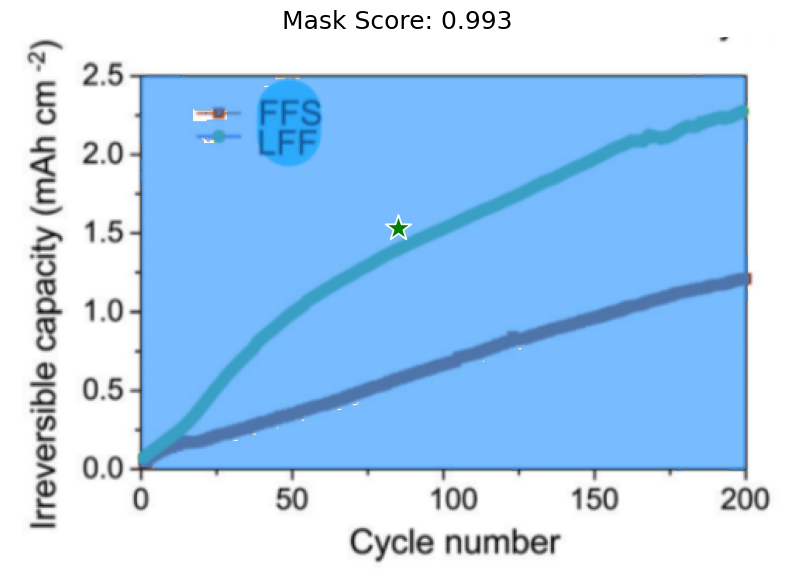

25 88
25 89
25 90
25 91
25 92
25 93
25 94
25 95
25 96
25 97
25 98
25 99
25 100
25 101
25 102
25 103
25 104
25 105
25 106
25 107
25 108
25 109
25 111
25 112
25 440
25 441
25 447
25 448
25 449
25 450
25 451
25 452
25 453
25 454
25 455
25 456
25 457
25 458
25 459
25 460
25 461
25 462
25 463
25 464
25 465
25 466
25 467
25 468
25 469
25 470
25 471
26 84
26 85
26 86
26 87
26 88
26 89
26 90
26 91
26 92
26 93
26 94
26 95
26 96
26 97
26 98
26 99
26 100
26 101
26 102
26 103
26 104
26 105
26 106
26 107
26 108
26 109
26 110
26 111
26 112
26 113
26 114
26 115
26 116
26 117
26 118
26 119
26 120
26 121
26 122
26 123
26 124
26 125
26 126
26 127
26 128
26 129
26 130
26 131
26 132
26 133
26 134
26 135
26 136
26 137
26 138
26 139
26 140
26 141
26 142
26 143
26 144
26 145
26 146
26 147
26 148
26 149
26 150
26 151
26 152
26 153
26 154
26 155
26 156
26 157
26 158
26 159
26 160
26 161
26 162
26 163
26 164
26 165
26 166
26 167
26 168
26 169
26 188
26 189
26 190
26 191
26 192
26 193
26 194
26 195
26 196
26 197

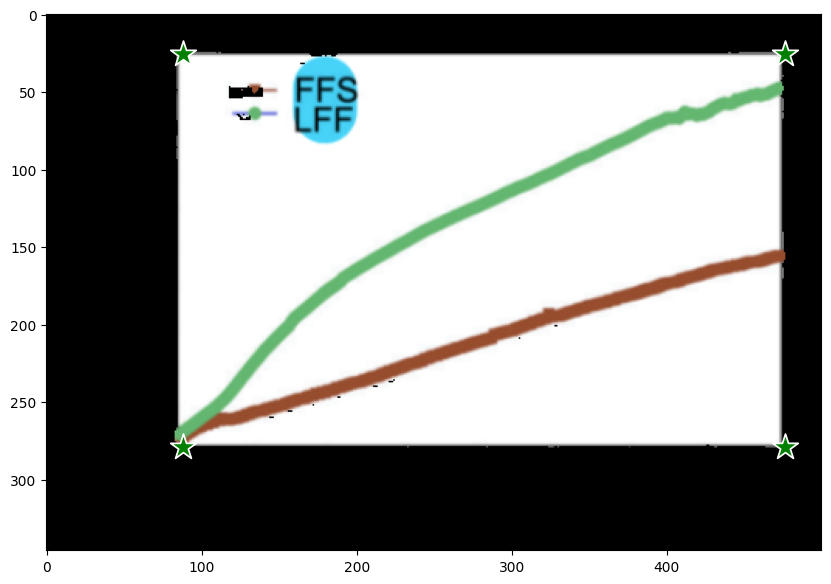

In [65]:
image_name = '../plot_images/'+str(image_number)+'.png'
image = cv2.imread(image_name)

height, width = image.shape[:2]
input_point = np.array([[width // 2, height // 2 - 50]])
input_label = np.array([1])

predictor.set_image(image)

masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
main_mask, main_mask_score = get_main_mask(masks, scores)
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(main_mask, plt.gca())

show_points(input_point, input_label, plt.gca())
plt.title(f"Mask Score: {main_mask_score:.3f}", fontsize=18)
plt.axis('off')
plt.show()

n_image = image.copy()
new_image, boundingBox = get_bounding_box(main_mask, n_image)

points = np.array([
    boundingBox["topLeft"], 
    [boundingBox["topLeft"][0], boundingBox["bottomRight"][1]], 
    [boundingBox["bottomRight"][0], boundingBox["topLeft"][1]], 
    boundingBox["bottomRight"]
])

plt.figure(figsize=(10,10))
plt.imshow(new_image)
show_points(points, np.array([1,1,1,1]), plt.gca())
plt.show()

In [74]:
'''
PROMPT TO GPT
------------------

Based on the plot:

1. What is the title of the x-axis?
2. What is the range of the x-axis?
3. What is the title of the y-axis?
4. What is the range of the y-axis?
5. What are the different types?

Can you provide the answers to the aforementioned questions in the following format:

answers = {
"x-axis": {
"title": [INSERT TITLE HERE IN STRING FORMAT],
"range":  [INSERT RANGE HERE IN NUMERICAL FORMAT],
},
"y-axis": {
"title": [INSERT TITLE HERE IN STRING FORMAT],
"range":  [INSERT RANGE HERE IN NUMERICAL FORMAT],
},
"types": [INSERT THE TYPES IN LIST OF TUPLES WHERE (TYPE NAME, MARKER COLOR)]
}

'''
answers = {
    "x-axis": {
    "title": "Cycle number",
    "range": [0, 200],
    },
    "y-axis": {
    "title": "Irreversible capacity (mAh cm^-2)",
    "range": [0, 2.5],
    },
    "types": [("FFS", "blue"), ("LFF", "green")]
}


In [75]:
threshold = 25

colors = [
    (35,78,156),
    (86,185,90), 
]

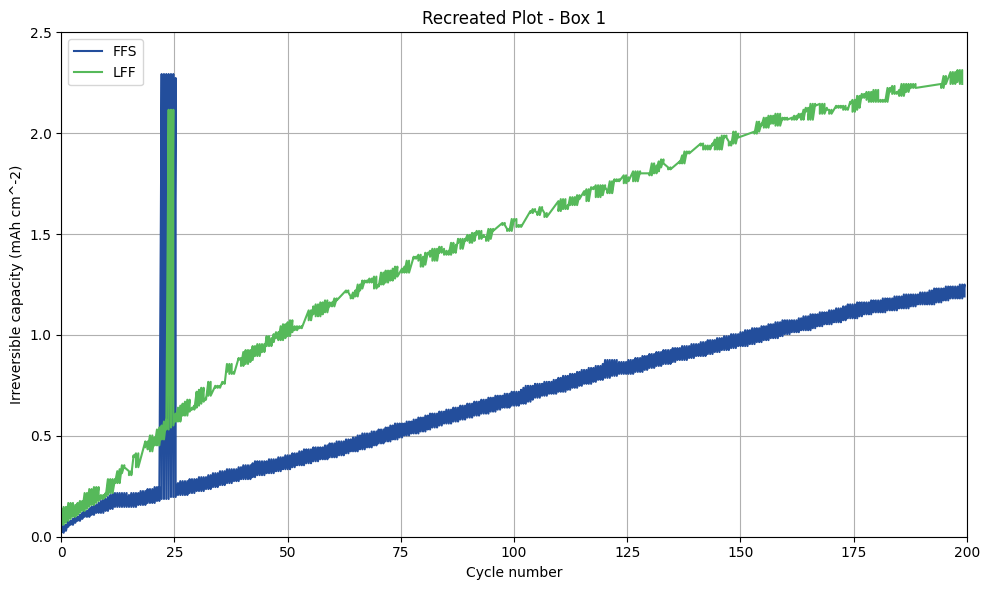

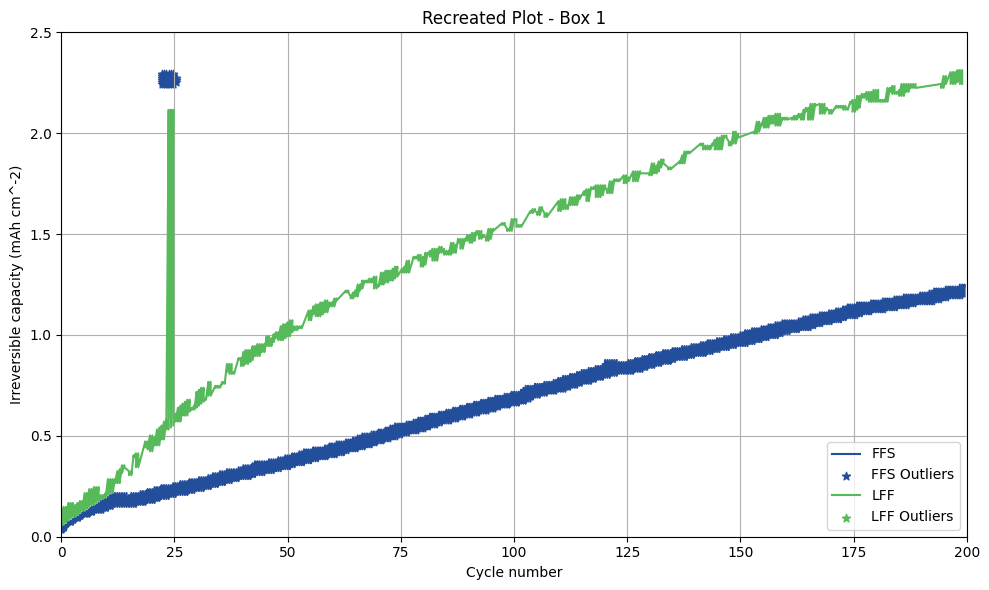

In [76]:
x_axis = answers["x-axis"]["range"]
y_axis = answers["y-axis"]["range"]

axis_labels = []
for label, marker in answers["types"]:
    axis_labels.append(label)

x_axis_title = answers["x-axis"]["title"]
y_axis_title = answers["y-axis"]["title"]

coordinates = [
    get_points(boundingBox, image_name, colors[0], wBox, hBox, x_axis, y_axis, threshold), 
    get_points(boundingBox, image_name, colors[1], wBox, hBox, x_axis, y_axis, threshold), 
]

create_directory('../bounding_box_images/'+str(image_number)+'_recreated_images/')

x_y(coordinates, "Recreated Plot - Box " + str(wBox), x_axis_title, y_axis_title, '../bounding_box_images/'+str(image_number)+'_recreated_images/line_' + str(wBox) + '.png', colors, x_axis, y_axis, axis_labels, '../bounding_box_images/'+ str(image_number) + '_recreated_images/line_' + str(wBox) + '.csv')

x_y(coordinates, "Recreated Plot - Box " + str(wBox), x_axis_title, y_axis_title, '../bounding_box_images/'+str(image_number)+'_recreated_images/outliers_line_' + str(wBox) + '.png', colors, x_axis, y_axis, axis_labels, '../bounding_box_images/'+str(image_number)+'_recreated_images/line_' + str(wBox) + '.csv', True)